In [ ]:
%config Completer.use_jedi = False

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import Accuracy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger

In [2]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
logger = TensorBoardLogger("tb_logs", name="my_model")

In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
batch_size=32
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
imgs, labels = next(iter(train_loader))

ValueError: num must be an integer with 1 <= num <= 10, not 11

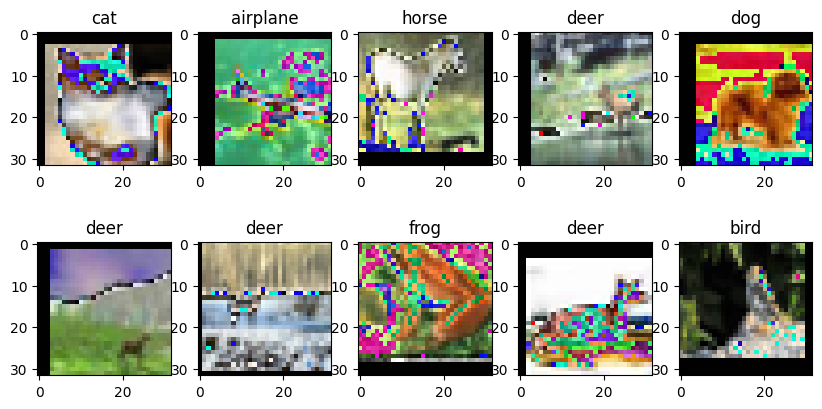

In [7]:

# Create a figure and axes
plt.figure(figsize=(10, 5))

# Iterate over the images and labels
for i, (img, label) in enumerate(zip(imgs, labels)):
    plt.subplot(2, 5, i + 1)

    # Display the image
    plt.imshow(transforms.ToPILImage()(img))
    # Add the label
    plt.title(CLASS_NAMES[label])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
class RCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(RCNN, self).__init__()
        
        # Load the pre-trained ResNet-50 model
        m = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Remove the last layer of ResNet-50
        modules = list(m.children())[:-1]
        self.features = nn.Sequential(*modules)
        
        # Add a custom fully connected layer
        self.fc_layer_1 = nn.Linear(m.fc.in_features, num_classes*2)
        self.classifier = nn.Linear(num_classes*2, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer_1(x)
        x = self.classifier(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)
        return x

In [9]:
class LightningRCNN(pl.LightningModule):
    def __init__(self, num_classes:int) -> None:
        super().__init__()
        self.model = RCNN(num_classes=num_classes)
        self.loss_module = nn.CrossEntropyLoss()
        self.save_hyperparameters()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        
        
    def forward(self, x):
        y = self.model(x)
        return y
    
    def training_step(self, batch, batch_idx):
       imgs, labels = batch
       preds = self.model(imgs)
       loss = self.loss_module(preds, labels)
       acc = self.accuracy(preds, labels)
       self.log_dict({'train_loss': loss, 'train_accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
       return loss
    
    def backward(self, loss):
        loss.backward()
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)

        loss = self.loss_module(preds, labels)
        acc = self.accuracy(preds, labels)
        self.log_dict({'validation_loss': loss, 'validation_accuracy': acc}, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        return {'validation_loss': loss, 'validation_accuracy': acc}

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        acc = self.accuracy(preds, labels)
        loss = self.loss_module(preds, labels)
        self.log_dict({'test_loss': loss, 'test_accuracy': acc}, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        return {'test_loss': loss, 'test_accuracy': acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
        

In [10]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

In [11]:
early_stop_callback = EarlyStopping(monitor="validation_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")
checkpoint_callback = ModelCheckpoint(dirpath="model_v1_resnet/", save_top_k=2, monitor="validation_loss")

In [17]:
trainer = pl.Trainer(accelerator="gpu", enable_checkpointing=True, max_epochs=30, logger=logger, callbacks=[early_stop_callback, checkpoint_callback], enable_progress_bar = False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
model = LightningRCNN(num_classes=10)

In [19]:
trainer.fit(model, train_loader, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
D:\conda\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory E:\idfy\model_v1_resnet exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | model       | RCNN               | 23.5 M
1 | loss_module | CrossEntropyLoss   | 0     
2 | accuracy    | MulticlassAccuracy | 0     
---------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5

In [24]:
# %load_ext tensorboard
%tensorboard --logdir tb_logs/my_model

Reusing TensorBoard on port 6006 (pid 11864), started 12:56:15 ago. (Use '!kill 11864' to kill it.)